<a href="https://colab.research.google.com/github/NadezhdaMalysheva/projects/blob/main/OB_vs_STAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls

%matplotlib inline

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import joblib
from tqdm.notebook import tqdm

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Nauch/df_done_sub.csv') #выборка с уже объединеными подклассами звезд 
df.head()

,objID,ra,dec,z,zErr,class,subClass,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z
0,1237679341106758387,37.470142,-5.554778,0.785255,0.000138,GALAXY,NaN,23.38412,23.00183,22.67571,21.95927,21.39581,20.01718,21.90474,21.99600,21.05722,20.29795
1,1237679341106757929,37.431501,-5.600435,1.285837,3.473993,QSO,NaN,22.52914,23.78679,23.21358,22.17294,21.80350,21.23949,20.26025,22.12909,21.14929,20.66354
2,1237679341106758149,37.388988,-5.556329,0.779955,0.000054,GALAXY,NaN,25.44541,23.13342,23.57675,24.34838,22.31492,20.38550,22.09762,23.74675,24.19759,20.62257
3,1237679440426172681,37.327114,-5.485252,0.714883,0.000028,GALAXY,NaN,25.43466,23.13782,23.31316,22.53812,22.60905,25.45580,22.96513,23.37321,22.59266,22.64923
4,1237679341106692861,37.315868,-5.519308,0.316563,0.000031,GALAXY,NaN,23.17536,21.34756,20.35171,20.05924,19.64511,21.14052,20.62957,19.60872,19.07587,18.90757


In [ ]:
df.shape

(4614588, 17)

In [ ]:
df[df['objID'] == 1237648720142401611]

,objID,ra,dec,z,zErr,class,subClass,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z
823072,1237648720142401611,146.71421,-1.041304,0.021222,0.000009,GALAXY,STARFORMING,19.08621,17.41779,16.59581,16.03497,15.68077,16.81934,15.38817,14.67877,14.25035,13.97063


In [ ]:
df = df.drop_duplicates('objID', keep = 'last')
df[df['objID'] == 1237648720142401611]

,objID,ra,dec,z,zErr,class,subClass,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z
4162963,1237648720142401611,146.71421,-1.041304,0.021275,0.000009,GALAXY,NaN,19.08621,17.41779,16.59581,16.03497,15.68077,16.81934,15.38817,14.67877,14.25035,13.97063


In [ ]:
df['ob'] = 1
df['ob'][df['subClass'] == 'OB'] = 0

In [ ]:
df1 = df.copy()
df['class'].head()

0    GALAXY
1       QSO
2    GALAXY
3    GALAXY
4    GALAXY
Name: class, dtype: object

In [ ]:
df = df[(df['class'] == 'STAR')] #оставляем в выборке только ОВ и другие звезды
df = df.drop(['class'], axis = 1)

In [ ]:
X =  df.drop(['subClass', 'objID', 'z', 'zErr', 'ra', 'dec', 'ob'], axis = 1).values
y = df['ob'].values

In [ ]:
df0 = pd.concat([df[df['ob']==0].sample(3000),  df[df['ob']==1].sample(3000)])#, df[df['class']==3].sample(1000), df[df['ob']==1][df[df['ob']==1]['class']==1].sample(1000)])

In [ ]:
sns.pairplot(data = df0.drop(['subClass', 'objID', 'z', 'zErr', 'ra', 'dec'], axis = 1), palette = 'Dark2', hue = 'ob')

In [ ]:
X.shape

(960363, 10)

In [ ]:
sub = df['subClass']
sub.shape

(960363,)

In [ ]:
df['subClass'].unique()

array(['F', 'G', 'WD', 'M', 'K', 'A', 'OB', 'LT', 'C'], dtype=object)

In [ ]:
def data_preparation(X, y, test_size = 0.3): #oбработка данных для классификаторов
    count = np.min(((y==1).sum(), (y==0).sum()))
    #print(count, (y==0).sum(), (y==1).sum())
    
    X0_train, X0_test, y0_train, y0_test = train_test_split(X[y==0], y[y==0], test_size=test_size, random_state = 43)
    count = (y==0).sum()
    
    countKK = 0
    for i in df['subClass'].unique():
      if i != 'OB':
        countKK +=1 
        ind = np.random.choice(y[sub == i].sum(), size=min(count//8, y[sub == i].sum()), replace=False)
        tr, tes, ytr, ytes = train_test_split(X[sub == i][ind], y[sub == i][ind], test_size=test_size, random_state = 43)
        if countKK == 1:
          X1_train = tr
          X1_test = tes
          y1_train = ytr
          y1_test = ytes
        else:          
          X1_train = np.concatenate((X1_train, tr))
          X1_test = np.concatenate((X1_test, tes))
          y1_train = np.concatenate((y1_train, ytr))
          y1_test = np.concatenate((y1_test, ytes))
    
    #count = X0_train.shape[0]
    #count1 = X0_test.shape[0]
    X_train, X_test = np.concatenate((X0_train, X1_train)), np.concatenate((X0_test, X1_test))##### для каждого подкласса 
    y_train, y_test = np.concatenate((y0_train, y1_train)), np.concatenate((y0_test, y1_test))

    X_test_not_scaling = X_test.copy()
    X_train_not_scaling = X_train.copy()
    X0_test_not_scaling = X0_test.copy()
    X1_test_not_scaling = np.concatenate((X1_test, X1_train[count:])).copy()
    #X3_test_not_scaling = np.concatenate((X3_test, X3_train[count//i3:])).copy()

    robust = RobustScaler()

    X_train = robust.fit_transform(X_train)
    X0_test = robust.transform(X0_test)
    X0_train = robust.transform(X0_train)
    #X1_test = robust.transform(X1_test)
    #X1_train = robust.transform(X1_train)
    X1_test = robust.transform(np.concatenate((X1_test, X1_train)))
    y1_test = np.concatenate((y1_test, y1_train))
    X1_train = robust.transform(X1_train)
    y1_train = y1_train
    X_test = robust.transform(X_test)
    

    return X_train, X_test, y_train, y_test, X_test_not_scaling, X_train_not_scaling, X0_test_not_scaling, X1_test_not_scaling,  X0_train, X0_test, y0_train, y0_test, X1_train, X1_test, y1_train, y1_test

In [ ]:
X_train, X_test, y_train, y_test, X_test_not_scaling, X_train_not_scaling, X0_test_not_scaling, X1_test_not_scaling,  X0_train, X0_test, y0_train, y0_test, X1_train, X1_test, y1_train, y1_test = data_preparation(X, y)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X0_test.shape, X1_test.shape)

(19219, 10) (8240, 10) (19219,) (8240,) (4120, 10) (13728, 10)


In [ ]:
from sklearn.manifold import TSNE
idx = np.random.permutation(19219)
x_tmp = TSNE(2).fit_transform(X_train)
x_tmp = x_tmp[idx]
y_tmp = y_train[idx]

In [ ]:
import seaborn as sns

In [ ]:
aaa = (y_tmp != 1)
x_aaa = x_tmp[aaa]
y_aaa = y_tmp[aaa]
bbb = (y_tmp != 0)
x_bbb = x_tmp[bbb]
y_bbb = y_tmp[bbb]

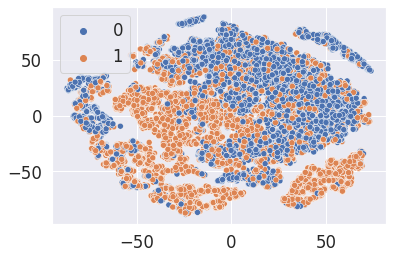

In [ ]:
sns.scatterplot(x=x_tmp[:, 0], y=x_tmp[:, 1], hue=y_tmp)

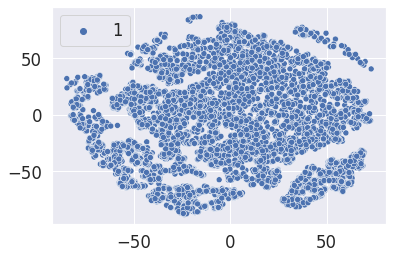

In [ ]:
sns.scatterplot(x=x_bbb[:, 0], y=x_bbb[:, 1], hue=y_bbb)

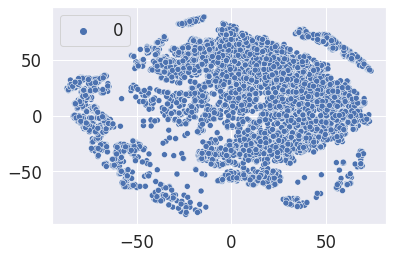

In [ ]:
sns.scatterplot(x=x_aaa[:, 0], y=x_aaa[:, 1], hue=y_aaa)

In [ ]:
import time
t = time.time()
rf = RandomForestClassifier(n_estimators=200, random_state=42, max_features=5, min_samples_leaf=1) 
rf.fit(X_train, y_train)
#rf = joblib.load('rf_new.pkl')
y_pred = rf.predict(X_test)
print('Classification Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
rf_train_acc = rf.score(X_train, y_train)
print('Training Score: ', rf_train_acc)
rf_test_acc = rf.score(X_test, y_test)
print('Testing Score: ', rf_test_acc)
print(-t + time.time())

Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.87      0.84      4120
           1       0.86      0.79      0.82      4120

    accuracy                           0.83      8240
   macro avg       0.83      0.83      0.83      8240
weighted avg       0.83      0.83      0.83      8240

Confusion Matrix: 
 [[3591  529]
 [ 876 3244]]
Training Score:  1.0
Testing Score:  0.8294902912621359
22.03578782081604


In [ ]:
rf.feature_importances_

array([0.13961261, 0.08180137, 0.05637992, 0.07552275, 0.19512705,
       0.10811628, 0.07903571, 0.05685069, 0.08241295, 0.12514067])

In [ ]:
from lightgbm import LGBMClassifier

gb = LGBMClassifier(n_estimators=500, num_leaves=60, learning_rate=0.01, max_depth=10)#, is_unbalance=True)
gb.fit(X_train, y_train)
pred = gb.predict(X_test)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = gb.score(X_train, y_train)
print('Training Score: ', gb_train_acc)
gb_test_acc = gb.score(X_test, y_test)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.88      0.84      4120
           1       0.87      0.78      0.82      4120

    accuracy                           0.83      8240
   macro avg       0.83      0.83      0.83      8240
weighted avg       0.83      0.83      0.83      8240

Confusion Matrix: 
 [[3620  500]
 [ 915 3205]]
Training Score:  0.8550392840418336
Testing Score:  0.8282766990291263


In [ ]:
gb.feature_importances_

array([5281, 2724, 2146, 2783, 3870, 3620, 2698, 1617, 1997, 2764])

In [ ]:
def roc(model, X_test, y_test, lab):
    from sklearn.metrics import roc_curve
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1], pos_label=lab)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show() 

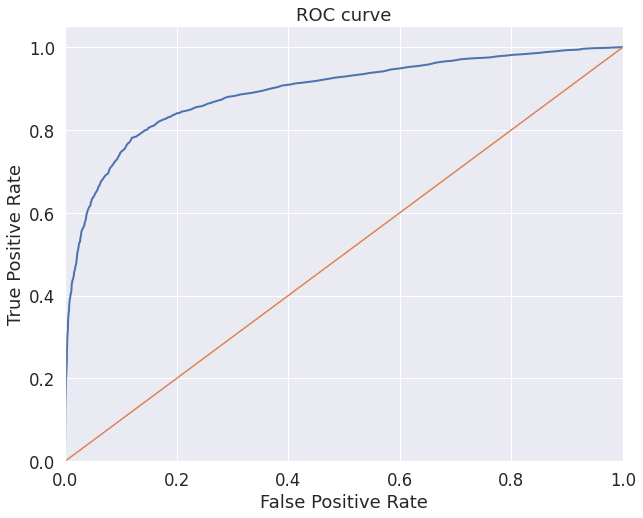

In [ ]:
roc(rf, X_test, y_test, 1)

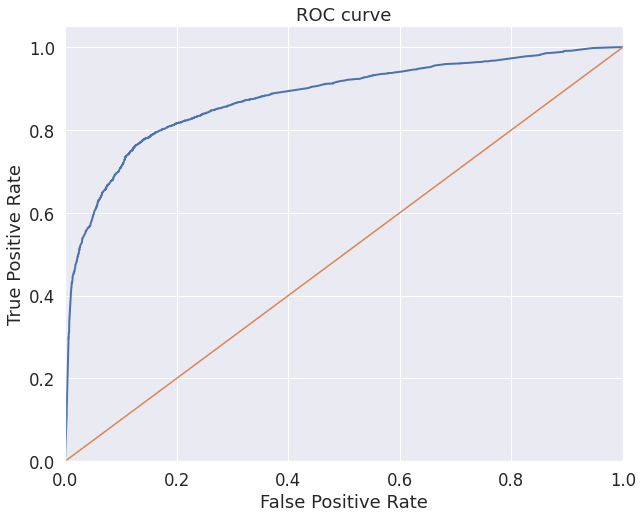

In [ ]:
roc(gb, X_test, y_test, 1)

In [ ]:
print_plot2(rf, X_test, y_test, X_test_not_scaling)

In [ ]:
print_plot2(rf, X_test, y_test, X_test_not_scaling)

In [ ]:
print_plot2(gb, X_test, y_test, X_test_not_scaling)